### Notebook 4: Case study (Alpine foreland) including synthetic measurements

This is a code for verifying whether the MCMC is working on my case study model. We create synthetic data measurements instead of using the available samples and see if we can recover the "unknown" input parameters from the model. If it works, then it means that the problem is not with the MCMC but with my data. My data is just not informative enough to improve the modeling substantially / lead to a reduction in uncertainty.

In [2]:
import pynoddy
import importlib
importlib.reload(pynoddy)
import pynoddy.history
import pynoddy.output
import pandas as pd
import numpy as np
import sys,os

sys.path.append(os.path.abspath('../functions'))
from exh_functions import *

In [4]:
#Note: for computing the noddy models, make sure that you have the noddy executable downloaded - you can find this on pynoddy's
#github page, all you need to do is clone the repository and set the path. Does not work on Mac.
noddy_path = r'C:\Users\Sofia\pynoddy\noddyapp\noddy_win64.exe'

In [5]:
folder = "CaseStudy"
output_folder = f"outputs/{folder}"
os.makedirs(output_folder, exist_ok=True)

### Load the model

Inputs

In [6]:
model = 'bregenz_synth'

In [3]:
#we use the same inputs as per the original MCMC model.
event_list = [21,22,24] #choose which events to modify
prop_list = ['Z', 'Slip'] #choose which properties to modify
lith_list = [13,15,17]
sample_num = [2,4,6]

In [4]:
# Use different input parameters than the original model
if os.path.exists('../models/hist_initial.his'):
    h = '../models/hist_initial.his'
    o = f'{output_folder}/{model}_noddy_out'
    pynoddy.compute_model(h, o, 
                      noddy_path = noddy_path)
    hist = pynoddy.history.NoddyHistory(h)
    out_initial = pynoddy.output.NoddyOutput(o)
else:
    #we start with new parameters for Z and Slip, that are very different from the original model.
    new_initial_params = [[21, -860.6186270541134, -12981.20232166832],
     [22, 1449.6491377332402, -10209.185549843101],
     [24, -1171.2056049491198, -3163.6213015919775]]
    
    for j,e in enumerate(event_list):
        for i, prop in enumerate(prop_list):
            hist.events[e].properties[prop] = new_initial_params[j][i+1]
    
    #save this new history to a different file
    hist_initial = f'{output_folder}/{model}_hist.his'
    out_initial = f'{output_folder}/{model}_noddy_out'
    hist.write_history(hist_initial)
    pynoddy.compute_model(hist_initial, out_initial, noddy_path = noddy_path)
    out_initial = pynoddy.output.NoddyOutput(out_initial)

synthetic_outputs/noddy_out


### 1. Extract the exhumation from original model (which in real life I don't know)
We will use the extracted exhumation as synthetic measurement data.

In [6]:
og_depths = []
for event_name, event in hist.events.items():
    if isinstance(event, pynoddy.events.Plug):
        z = event.properties['Z']
        
        og_depths.append(z)

samples = pd.read_csv('../cluster/data/input_data/bregenz_exh.csv')
diff = np.load('../cluster/data/input_data/diff.npy')

In [7]:
diff = [diff[i] for i in sample_num]
og_depths = [og_depths[i] for i in sample_num]
samples = samples.iloc[sample_num]

In [8]:
og_params = []
for i in event_list:
    event_data = [i]
    for j, props in enumerate(prop_list):
        propert = hist.events[i].properties[props]
        event_data.append(propert)
    og_params.append(event_data)
    
col = ['event_name'] + prop_list
og_params_df = pd.DataFrame(og_params, columns = col)

I want to use these exhumation values to be able to recover the initial parameters (params) when I start with a random model. I will generate new starting parameters randomly by perturbing the initial ones, and then start the MCMC from there using the current_exhumation as likelihood.

### 2. Generate an initial model (equivalent to the "best guess") from the original parameters

In [9]:
#og_params = [[21,-900, -12500],[22,1500, -10000],[24,-1500, -3500]]
synthetic_data = [[21, 3400],[22, 3300],[24,5400]]
std_list = [150,400]

In [10]:
#new_initial_params = []
#for i, par in enumerate(og_params):
#    event = par[0]
#    new_params = [event]
#    for j in range(1, len(par)):
#        new_param = np.random.normal(par[j], std_list[j-1])
#        new_params.append(new_param)
#    new_initial_params.append(new_params)

Create a new model using these new initial parameters

In [11]:
#for j,e in enumerate(event_list):
#    for i, prop in enumerate(prop_list):
#        hist.events[e].properties[prop] = new_initial_params[j][i+1]   

In [12]:
current_exhumation,_,_ = calc_new_position(hist, diff,
                                        og_depths, lith_list, samples.copy())
samples.reset_index(drop = True, inplace = True)
samples['exhumation'] = current_exhumation['exhumation']

synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out


In [13]:
current_exhumation.reset_index(drop=True, inplace=True)

In [14]:
current_exhumation

,X,Y,Z,sample,group,exhumation,respected
0,13815.5822,12609.0,541,50,d,3441.480077,0
1,18309.8314,15806.0,636,40,d,3302.714042,0
2,21076.8867,17473.0,765,30,a,5431.571916,0


### 3. MCMC simulation 

In [15]:
n_draws = 1000

In [49]:
current_params = og_params

For storage:

In [17]:
accepted = 0
total_runs = 0
rejected= 0
sigma = 800

In [18]:
accepted_params = pd.DataFrame(columns = ['Event'] + prop_list + ['n_draw'])
rejected_params = pd.DataFrame(columns = ['Event'] + prop_list + ['n_draw'])
accepted_exhumation = []
rejected_exhumation = []

Simulation:

In [19]:
def cont_likelihood(mu, sigma, x):
    #mu is the model prediciton, sigma is the errorof the data and x is the observed data
    # Calculate the likelihood using the Gaussian PDF
    pdf = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return pdf

def synthetic_likelihood(exhumation_df, synthetic_data, sigma):
    #The bigger the sigma, the bigger the likelihood
    likelihood = 1.0
    
    for i in range(len(synthetic_data)):
        modeled_value = exhumation_df.iloc[i]['exhumation']
        data = synthetic_data[i][1]
        
        like_value = cont_likelihood(modeled_value, sigma, data)
        likelihood *= like_value
    
    return likelihood

In [45]:
def disturb_property(PH_local, event_list, prop_list, std_list):
    data = []
    for i in event_list:
        event_data = [i]
        for j, prop in enumerate(prop_list):
            new_param = disturb_value_rounded(PH_local.events[i], prop_list[j], std_list[j])
            rounded_param = round(new_param, -2)
            event_data.append(rounded_param)
            
        data.append(event_data)
    col = ['event_name'] + prop_list
    df = pd.DataFrame(data, columns = col)
    
    return data, df

In [20]:
def calc_new_position(hist, diff, og_depths, lith_list,samples):
    samples_noddy_pos = []
    for i in lith_list:
        p,_,out,new_hist = ExtractCoords(hist, lith = [i], res = 1)
        t = p[...,2].min()
        z = (t*1000) / 3681.39
        samples_noddy_pos.append(z)
    
    if len(lith_list) > 1:
        proposed_exhumation = [x - y - z for x,y,z in zip(samples_noddy_pos, diff, og_depths)]
    else:
        proposed_exhumation = samples_noddy_pos - diff - og_depths
    samples['exhumation'] = proposed_exhumation
    return samples, samples_noddy_pos, new_hist

In [51]:
for i in range(n_draws):
    while accepted < n_draws:
        
        current_hist = copy.deepcopy(hist)
        proposed_params, proposed_params_df = disturb_property(current_hist, event_list, prop_list, std_list)
        try:
            proposed_exhumation,_,new_hist = calc_new_position(current_hist, diff, og_depths, lith_list, samples.copy())
        except IndexError:
            print('Repeating calculation')
            continue
        
        #Likelihood and prior probabilities
        current_prior = prior_dist(og_params, current_params, std_list)
        proposed_prior = prior_dist(og_params, proposed_params, std_list)
        current_likelihood = synthetic_likelihood(current_exhumation, synthetic_data, sigma)
        proposed_likelihood = synthetic_likelihood(proposed_exhumation, synthetic_data, sigma)
        print(f"cp {current_prior}, pp {proposed_prior}")
        print(f"cl {current_likelihood}, pl {proposed_likelihood}")
        
        #acceptance ratio and thresholds
        acceptance_ratio = (proposed_prior * proposed_likelihood) / (current_prior * current_likelihood)
        print(f"acc_ratio: {acceptance_ratio}")
        threshold = np.random.rand(1)
        
        if acceptance_ratio > threshold:
            current_params_df = proposed_params_df
            current_params = proposed_params
            current_exhumation = proposed_exhumation
            hist = current_hist
            
            accepted += 1
            print(f"accepted model {accepted} out of {total_runs+1}")
            
            np.save(f"{output_folder}/{model}_accepted_exh_{accepted}.npy", current_exhumation['exhumation'])
            np.save(f"{output_folder}/{model}_accepted_params_{accepted}.npy", current_params)
            
            #storage
            #accepted_params = pd.concat([accepted_params,current_params_df], ignore_index=True)
            #accepted_exhumation.append(current_exhumation['exhumation'])
            accepted_hist = f'{output_folder}/{model}_acc_hist_{accepted}.his'
            os.rename(new_hist, accepted_hist)
            
        else:
            rejected += 1
            #rejected_params = pd.concat([rejected_params, proposed_params_df], ignore_index=True)
            
            np.save(f"{output_folder}/{model}_rejected_exh_{rejected}.npy", proposed_exhumation['exhumation'])
            np.save(f"{output_folder}/{model}_rejected_params_{rejected}.npy", proposed_params)

            rejected_hist = f'{output_folder}/{model}_rej_hist_{rejected}.his'
            os.rename(new_hist, rejected_hist)
                
        total_runs += 1
        

synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.8664082426620078e-17, pp 1.0476810643611118e-23
cl 1.2374730499997911e-10, pl 1.2068653124689578e-10
acc_ratio: 5.474513188385956e-07
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.8664082426620078e-17, pp 1.7712977159819246e-19
cl 1.2374730499997911e-10, pl 1.2371919110583912e-10
acc_ratio: 0.009488252666488325
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.8664082426620078e-17, pp 2.0523568992729988e-19
cl 1.2374730499997911e-10, pl 1.2396622235474428e-10
acc_ratio: 0.011015744629102238
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.8664082426620078e-17, pp 4.4487779529808545e-18
cl 1.2374730499997911e-10, pl 1.237718298865178e-10
acc_ratio: 0.2384076287972243
accepted model 1 out of 9
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.44877795298085

Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.5153179341810582e-18, pp 3.205498561229299e-18
cl 1.2329310960666023e-10, pl 1.2382702892157825e-10
acc_ratio: 2.124557402264233
accepted model 8 out of 38
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.205498561229299e-18, pp 4.152504957536474e-19
cl 1.2382702892157825e-10, pl 1.2350428576291974e-10
acc_ratio: 0.12920554404904427
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.205498561229299e-18, pp 1.7833030877005415e-19
cl 1.2382702892157825e-10, pl 1.231246802908091e-10
acc_ratio: 0.05531707888513731
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.205498561229299e-18, pp 6.809006049263149e-20
cl 1.2382702892157825e-10, pl 1.2287715983159444e-10
acc_ratio: 0.021078701104953423
synthetic_outputs/temp_out
synthetic_o

Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.1133145172272744e-19, pp 2.054408952780572e-21
cl 1.2388098467990727e-10, pl 1.2380797268189702e-10
acc_ratio: 0.01844221116009069
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.1133145172272744e-19, pp 3.43803724233375e-23
cl 1.2388098467990727e-10, pl 1.2389365029119965e-10
acc_ratio: 0.00030884253232982934
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.1133145172272744e-19, pp 2.0384737922500354e-21
cl 1.2388098467990727e-10, pl 1.2182758354797602e-10
acc_ratio: 0.01800645588967252
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.1133145172272744e-19, pp 7.377309994625736e-23
cl 1.2388098467990727e-10, pl 1.2366944622090882e-10
acc_ratio: 0.0006615123065788027
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.1133145172272744e-1

Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.3933594313031144e-18, pp 8.03648094374468e-20
cl 1.2350301853216942e-10, pl 1.2227516145071604e-10
acc_ratio: 0.02344750993037097
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.3933594313031144e-18, pp 1.9498126365723917e-19
cl 1.2350301853216942e-10, pl 1.2272628981665086e-10
acc_ratio: 0.05709828317003308
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.3933594313031144e-18, pp 4.476419740816773e-19
cl 1.2350301853216942e-10, pl 1.227076878930078e-10
acc_ratio: 0.13106753739473448
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.3933594313031144e-18, pp 2.1826707821577894e-19
cl 1.2350301853216942e-10, pl 1.2237138677482763e-10
acc_ratio: 0.06373245982798635
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthet

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 6.429140911592322e-19, pp 1.7639583875526867e-19
cl 1.2344838508557922e-10, pl 1.233977054321216e-10
acc_ratio: 0.27425658395407865
accepted model 35 out of 141
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.7639583875526867e-19, pp 1.0556147359702076e-22
cl 1.233977054321216e-10, pl 1.218535894386407e-10
acc_ratio: 0.0005909467534088202
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.7639583875526867e-19, pp 3.516902228688194e-21
cl 1.233977054321216e-10, pl 1.2333170750887214e-10
acc_ratio: 0.01992689440131536
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.7639583875526867e-19, pp 9.264404053761606e-22
cl 1.233977054321216e-10, pl 1.237757715513038e-10
acc_ratio: 0.005268144882379035
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.7639583875526867e-19, pp 6.165839525820029e-21

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.856169870332667e-19, pp 3.1247039232827165e-19
cl 1.2268144401565e-10, pl 1.2322599754624617e-10
acc_ratio: 0.53594308305398
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.856169870332667e-19, pp 3.13172415777985e-22
cl 1.2268144401565e-10, pl 1.221343026021596e-10
acc_ratio: 0.0005323884368349683
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.856169870332667e-19, pp 4.6996474624629036e-21
cl 1.2268144401565e-10, pl 1.2231333067573957e-10
acc_ratio: 0.00800104160276833
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.856169870

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.017727801395453e-18, pp 7.888679418056103e-18
cl 1.2337591772189653e-10, pl 1.2383877657282314e-10
acc_ratio: 7.780346266762782
accepted model 51 out of 209
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 7.888679418056103e-18, pp 4.074472321745183e-18
cl 1.2383877657282314e-10, pl 1.2353732648040364e-10
acc_ratio: 0.5152388591918329
accepted model 52 out of 210
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.074472321745183e-18, pp 1.0319525925934093e-19
cl 1.2353732648040364e-10, pl 1.2345834158612832e-10
acc_ratio: 0.025311076413543798
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.074472321745183e-18, pp 1.843515930403201e-18
cl 1.2353732648040364e-10, pl 1.2353732648040364e-10
acc_ratio: 0.4524551364760735
accepted model 53 out of 212
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_o

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.4527657041511206e-18, pp 1.152984067670422e-19
cl 1.2382709638503922e-10, pl 1.234081460955293e-10
acc_ratio: 0.04684846653596638
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.4527657041511206e-18, pp 9.038237272209634e-18
cl 1.2382709638503922e-10, pl 1.238351911198516e-10
acc_ratio: 3.6851575745617353
accepted model 64 out of 244
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 9.038237272209634e-18, pp 1.5388980640587858e-19
cl 1.238351911198516e-10, pl 1.2361812793636302e-10
acc_ratio: 0.016996683942501287
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 9.038237272209634e-18, pp 1.0567753755926786e-19
cl 1.238351911198516e-10, pl 1.2223942173041535e-10
acc_ratio: 0.01154160361375605
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic

Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.4822788618314567e-19, pp 2.022149514896421e-19
cl 1.236948756136083e-10, pl 1.2372418606263232e-10
acc_ratio: 0.8148273386308792
accepted model 75 out of 274
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.022149514896421e-19, pp 1.4950366062974989e-21
cl 1.2372418606263232e-10, pl 1.2100509475204702e-10
acc_ratio: 0.0072308210502743655
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.022149514896421e-19, pp 9.368907797547103e-21
cl 1.2372418606263232e-10, pl 1.2339162777007446e-10
acc_ratio: 0.046206895372696566
synt

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.4898026383751324e-17, pp 8.207250791080289e-19
cl 1.2388098467990727e-10, pl 1.2363060790702901e-10
acc_ratio: 0.05497817526244298
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.4898026383751324e-17, pp 3.176443199353475e-18
cl 1.2388098467990727e-10, pl 1.237718298865178e-10
acc_ratio: 0.21302448189906972
accepted model 83 out of 305
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.176443199353475e-18, pp 5.9903218194640456e-21
cl 1.237718298865178e-10, pl 1.226094549629667e-10
acc_ratio: 0.0018681477065118988
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.176443199353475e-18, pp 2.640587260833299e-19
cl 1.237718298865178e-10, pl 1.2357887558765292e-10
acc_ratio: 0.08300071959395629
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.4964287432383085e-19, pp 1.0341094757674385e-22
cl 1.2365435737870335e-10, pl 1.1973909769693356e-10
acc_ratio: 0.00018218493918332551
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.4964287432383085e-19, pp 5.5979901795031526e-21
cl 1.2365435737870335e-10, pl 1.2359867897095132e-10
acc_ratio: 0.010180191190479993
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.4964287432383085e-19, pp 4.270244796217036e-20
cl 1.2365435737870335e-10, pl 1.2320127982819486e-10
acc_ratio: 0.07740659512348687
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.4964287432383085e-19, pp 2.5358681957206866e-19
cl 1.2365435737870335e-10, pl 1.238605142730103e-10
acc_ratio: 0.4621357104779453
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.4964287432383085e-1

Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.5774261734722694e-20, pp 4.386283415097037e-20
cl 1.233238797808613e-10, pl 1.230855207608065e-10
acc_ratio: 1.6985183515506408
accepted model 103 out of 369
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.386283415097037e-20, pp 2.495700477639036e-21
cl 1.230855207608065e-10, pl 1.2320127982819486e-10
acc_ratio: 0.05695135013965141
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.386283415097037e-20, pp 8.095176773367361e-22
cl 1.230855207608065e-10, pl 1.2247165468193698e-10
acc_ratio: 0.018363618641851324
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.386283415097037e-20, pp 4.477808273361281e-22
cl 1.230855207608065e-10

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.3904657859125945e-19, pp 1.0243169662081944e-20
cl 1.2164054774877314e-10, pl 1.2299473639663525e-10
acc_ratio: 0.03054802652086444
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.3904657859125945e-19, pp 4.296302684146198e-19
cl 1.2164054774877314e-10, pl 1.2190973312934558e-10
acc_ratio: 1.2699760127131439
accepted model 111 out of 403
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.296302684146198e-19, pp 2.0469197639791255e-21
cl 1.2190973312934558e-10, pl 1.226131576224841e-10
acc_ratio: 0.004791865778352644
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.296302684146198e-19, pp 5.048774095631759e-20
cl 1.2190973312934558e-10, pl 1.2346738918247894e-10
acc_ratio: 0.11901589100330272
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synth

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.467624766552625e-19, pp 4.2089994150690745e-19
cl 1.2389365029119965e-10, pl 1.2262834900595112e-10
acc_ratio: 0.9324896239668933
accepted model 121 out of 435
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.2089994150690745e-19, pp 2.0710610529746657e-19
cl 1.2262834900595112e-10, pl 1.232461291382224e-10
acc_ratio: 0.4945343276038524
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.2089994150690745e-19, pp 6.791333182143372e-23
cl 1.2262834900595112e-10, pl 1.228556616457443e-10
acc_ratio: 0.00016165177064565985
synthetic_outputs/temp_out
Repeating calculation
syn

Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.1189715412623596e-18, pp 1.0404916867428444e-20
cl 1.2208830215831064e-10, pl 1.2383421124201553e-10
acc_ratio: 0.009431617106166456
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.1189715412623596e-18, pp 3.803361829069778e-19
cl 1.2208830215831064e-10, pl 1.2155947520265489e-10
acc_ratio: 0.3384257223458477
accepted model 129 out of 469
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.803361829069778e-19, pp 1.557245149007198e-18
cl 1.2155947520265489e-10, pl 1.2235757687029963e-10
acc_ratio: 4.121273100099278
accepted model 130 out of 470
synthetic_outputs/temp_o

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 6.471275250363713e-18, pp 2.4721283039878514e-18
cl 1.2379714008288932e-10, pl 1.2354814489489139e-10
acc_ratio: 0.381247277690749
accepted model 137 out of 500
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.4721283039878514e-18, pp 3.09170331306981e-19
cl 1.2354814489489139e-10, pl 1.2245386705182275e-10
acc_ratio: 0.12395472328438427
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.4721283039878514e-18, pp 8.753112482166797e-20
cl 1.2354814489489139e-10, pl 1.238351911198516e-10
acc_ratio: 0.03548945682722291
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.4721283039878514e-18, pp 4.1939018280382915e-18
cl 1.2354814489489139e-10, pl 1.2363285472373635e-10
acc_ratio: 1.697637350610419
accepted model 138 out of 503
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
s

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.712814197009711e-19, pp 5.641660420831428e-19
cl 1.23802202423836e-10, pl 1.237871648258235e-10
acc_ratio: 0.9874249299346416
accepted model 145 out of 533
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.641660420831428e-19, pp 5.643784278801902e-19
cl 1.237871648258235e-10, pl 1.2375868708974446e-10
acc_ratio: 1.0001463190964102
accepted model 146 out of 534
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.643784278801902e-19, pp 3.8280991600875504e-20
cl 1.2375868708974446e-10, pl 1.2391454891746174e-10
acc_ratio: 0.06791401093783826
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.643784278801902e-19, pp 3.126083293833094e-20
cl 1.2375868708974446e-10, pl 1.2345834158612832e-10
acc_ratio: 0.055255420135533855
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synt

Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.972366992874597e-18, pp 2.368207368039525e-19
cl 1.236948756136083e-10, pl 1.2324388934959434e-10
acc_ratio: 0.03950817133897328
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.972366992874597e-18, pp 2.6063786211095655e-19
cl 1.236948756136083e-10, pl 1.2338067315408735e-10
acc_ratio: 0.04352977729412142
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.972366992874597e-18, pp 1.0013275437856083e-18
cl 1.236948756136083e-10, pl 1.2284526772401747e-10
acc_ratio: 0.16650849633473963
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 6.512263424485824e-18, pp 4.895888563119722e-19
cl 1.220374115035446e-10, pl 1.2325838182094335e-10
acc_ratio: 0.07593168526574379
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 6.512263424485824e-18, pp 3.9821277771389814e-20
cl 1.220374115035446e-10, pl 1.214968554527266e-10
acc_ratio: 0.006087728592082326
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 6.512263424485824e-18, pp 2.2236876939737197e-18
cl 1.220374115035446e-10, pl 1.237314266182605e-10
acc_ratio: 0.3462014368052434
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 6.512263424485824e-18, pp 2.4189939013452873e-20
cl 1.220374115035446e-10, pl 1.226131576224841e-10
acc_ratio: 0.003732045270722521
synthetic_outputs/t

Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.491742757176189e-18, pp 4.2280751802523785e-20
cl 1.2390315249307992e-10, pl 1.2180299780955474e-10
acc_ratio: 0.011903538499255354
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.491742757176189e-18, pp 1.9673089968445423e-19
cl 1.2390315249307992e-10, pl 1.233663332678083e-10
acc_ratio: 0.056097645984773584
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.491742757176189e-18, pp 3.2256292653967302e-18
cl 1.2390315249307992e-10, pl 1.2383877657282314e-10
acc_ratio: 0.9233078038311994
accepted model 165 out of 628
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.2256292653967302e-18, pp 1.792621578628551e-19
cl 1.2383877657282314e-10, pl 1.2351952346389948e-10
acc_ratio: 0.055431052369455655
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_ou

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.765726252125731e-18, pp 1.757576183043243e-18
cl 1.2373585654323646e-10, pl 1.239235624307342e-10
acc_ratio: 0.9968942830238412
accepted model 175 out of 661
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.757576183043243e-18, pp 4.049389976599468e-18
cl 1.239235624307342e-10, pl 1.232364236814725e-10
acc_ratio: 2.2911875551944743
accepted model 176 out of 662
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.049389976599468e-18, pp 5.320121571733778e-20
cl 1.232364236814725e-10, pl 1.2083843100373565e-10
acc_ratio: 0.012882434533469007
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.049389976599468e-18, pp 3.0969830348294577

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 8.978553953818428e-19, pp 2.666016384558809e-19
cl 1.2372418606263232e-10, pl 1.230835845886723e-10
acc_ratio: 0.2953941891053889
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 8.978553953818428e-19, pp 4.035670652512171e-18
cl 1.2372418606263232e-10, pl 1.238497445526675e-10
acc_ratio: 4.499350536613707
accepted model 191 out of 695
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.035670652512171e-18, pp 4.960386235784236e-18
cl 1.238497445526675e-10, pl 1.2395671531600114e-10
acc_ratio: 1.2301971638676634
accepted model 192 out of 696
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.960386235784236e-18, pp 2.8892887584224953e-19
cl 1.2395671531600114e-10, pl 1.2388013620957134e-10
acc_ratio: 0.05821126924587985
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.960386235784236e-18, pp

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.144019365789603e-19, pp 3.698935552350008e-19
cl 1.2274866976910443e-10, pl 1.2308328389096236e-10
acc_ratio: 1.1797061203354744
accepted model 197 out of 729
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.698935552350008e-19, pp 8.921395717488243e-20
cl 1.2308328389096236e-10, pl 1.2334152340193075e-10
acc_ratio: 0.24169422420688066
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.698935552350008e-19, pp 2.631815677850831e-22
cl 1.2308328389096236e-10, pl 1.2173294119234822e-10
acc_ratio: 0.0007037003151126726
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.698935552350008e-19, pp 4.999928247984644e-19
cl 1.2308328389096236e-10, pl 1.2359867897095132e-10
acc_ratio: 1.3573809869213205
accepted model 198 out of 732
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.999928247984644e-

synthetic_outputs/temp_out
cp 1.2909652941652197e-19, pp 7.36412425701781e-21
cl 1.231246802908091e-10, pl 1.2170721943152952e-10
acc_ratio: 0.05638684113727002
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.2909652941652197e-19, pp 9.83523723242511e-23
cl 1.231246802908091e-10, pl 1.2304910203635584e-10
acc_ratio: 0.0007613837539010082
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.2909652941652197e-19, pp 1.6294921097337982e-20
cl 1.231246802908091e-10, pl 1.2193319630203944e-10
acc_ratio: 0.12500130223627892
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.2909652941652197e-19, pp 8.970399233347938e-20
cl 1.231246802908091e-10, pl 1.2363040904625732e-10
acc_ratio: 0.6977139324602306
accepted model 206 out of 768
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 8.970399233347938e-20, pp 1.0239670992533523e-22
cl 1.2363040904625732e-10, 

Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.5019550642248205e-18, pp 5.091455994743927e-19
cl 1.2372320706315235e-10, pl 1.2370641174425295e-10
acc_ratio: 0.3389425526256387
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.5019550642248205e-18, pp 9.925069605584983e-19
cl 1.2372320706315235e-10, pl 1.2382513676522337e-10
acc_ratio: 0.661354433157767
accepted model 213 out of 798
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 9.925069605584983e-19, pp 7.750666509631931e-22
cl 1.2382513676522337e-10, pl 1.2031853157670297e-10
acc_ratio: 0.0007588032741978792
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 9.925069605584983e-19, pp 3.773421939508853e-20
cl 1.2382513676522337e-10, pl 1.2340430738007741e-10
acc_ratio: 0.03788988712603042
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.092923215326299e-19, pp 1.627534501266875e-20
cl 1.235104720471883e-10, pl 1.2297596297565393e-10
acc_ratio: 0.07742716518187398
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.092923215326299e-19, pp 1.2202264212330503e-20
cl 1.235104720471883e-10, pl 1.2222458187537065e-10
acc_ratio: 0.05769549553341493
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.092923215326299e-19, pp 7.462449429066884e-22
cl 1.235104720471883e-10, pl 1.227835422259011e-10
acc_ratio: 0.0035445775499996944
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.092923215326299e-19, pp 1.5027256414232474e-21
cl 1.235104720471883e-10, pl 1.2316687028571663e-10
acc_ratio: 0.007160057764687243
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.092923215326299e-19, pp 7.118202122835059e-20
cl 1.235104720471883e-10, pl 1.

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 8.798160650952736e-20, pp 1.7945952972080985e-22
cl 1.236957228150715e-10, pl 1.237871648258235e-10
acc_ratio: 0.0020412470540961767
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 8.798160650952736e-20, pp 1.6632114946249984e-22
cl 1.236957228150715e-10, pl 1.2320329669863867e-10
acc_ratio: 0.0018828825745966383
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 8.798160650952736e-20, pp 5.454142265434459e-22
cl 1.236957228150715e-10, pl 1.2340099702637102e-10
acc_ratio: 0.006184414076236994
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 8.798160650952736e-20, pp 6.950891051667218e-24
cl 1.236957228150715e-10, pl 1.2334026104204233e-10
acc_ratio: 7.877687960658504e-05
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 8.798160650952736e-20, pp 1.8993488350328628e-21
cl 1.236957228150715e-10, 

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.0271822632729486e-18, pp 1.3440729088091202e-20
cl 1.238605142730103e-10, pl 1.2361497059268924e-10
acc_ratio: 0.0033308857230738894
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.0271822632729486e-18, pp 2.5535344802270684e-21
cl 1.238605142730103e-10, pl 1.2153964643329488e-10
acc_ratio: 0.0006221935873880474
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.0271822632729486e-18, pp 9.070387187464983e-22
cl 1.238605142730103e-10, pl 1.2269320181615153e-10
acc_ratio: 0.00022310646845955756
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.0271822632729486e-18, pp 3.863054856790189e-19
cl 1.238605142730103e-10, pl 1.2388000443971783e-10
acc_ratio: 0.09593960437303764
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.0271822632729486e-1

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.7039626761332604e-18, pp 1.300231964394833e-20
cl 1.235780965142862e-10, pl 1.2323129016317118e-10
acc_ratio: 0.007609221994348371
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.7039626761332604e-18, pp 6.146998333426637e-21
cl 1.235780965142862e-10, pl 1.239971331748867e-10
acc_ratio: 0.0036197048575268126
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.7039626761332604e-18, pp 1.7180307922471831e-18
cl 1.235780965142862e-10, pl 1.2357676440603804e-10
acc_ratio: 1.0082452490441312
accepted model 242 out of 937
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.7180307922471831e-18, pp 2.3392586730644083e-23
cl 1.2357676440603804e-10, pl 1.219061950908966e-10
acc_ratio: 1.3431863242485117e-05
synthetic_outputs/temp_out
sy

Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 6.077868856342082e-19, pp 2.7950692851475976e-19
cl 1.2360799981250303e-10, pl 1.2345834158612832e-10
acc_ratio: 0.4593197425939742
accepted model 253 out of 968
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.7950692851475976e-19, pp 1.0156256829992025e-21
cl 1.2345834158612832e-10, pl 1.2278869372747152e-10
acc_ratio: 0.0036139241840211665
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.7950692851475976e-19, pp 2.880847003556645e-20
cl 1.2345834158612832e-10, pl 1.2233746927534125e-10
acc_ratio: 0.10213313666840612
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.7950692851475976e-19, pp 1.2058545865475557e-20
cl 1.2345834158612832e-10, pl 1.226316009832923e-10
acc_ratio: 0.042853304922084896
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
s

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.8696481806747134e-18, pp 1.7463957933291683e-19
cl 1.2391405866360442e-10, pl 1.2322079732908058e-10
acc_ratio: 0.09288513528310206
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.8696481806747134e-18, pp 3.300522790023384e-20
cl 1.2391405866360442e-10, pl 1.2368981766131465e-10
acc_ratio: 0.017621229678290305
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.8696481806747134e-18, pp 1.3046715714398408e-19
cl 1.2391405866360442e-10, pl 1.2387507925439679e-10
acc_ratio: 0.06975971077725024
accepted model 262 out of 1004
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.3046715714398408e-19, pp 8.336843938739132e-21
cl 1.2387507925439679e-10, pl 1.2360708907597322e-10
acc_ratio: 0.06376170272485247
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.3046715714398408e-19, pp 1.066617773453

synthetic_outputs/temp_out
cp 4.270284729386179e-19, pp 9.514903858239072e-22
cl 1.2372320706315235e-10, pl 1.2396622235474428e-10
acc_ratio: 0.002232542674712864
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.270284729386179e-19, pp 1.0033960291786982e-21
cl 1.2372320706315235e-10, pl 1.235766297519245e-10
acc_ratio: 0.0023469331665791583
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.270284729386179e-19, pp 6.64624038866164e-19
cl 1.2372320706315235e-10, pl 1.2351952346389948e-10
acc_ratio: 1.5538305304098992
accepted model 270 out of 1039
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 6.64624038866164e-19, pp 8.180421691523845e-19
cl 1.2351952346389948e-10, pl 1.228985427477887e-10
acc_ratio: 1.2246465749098836
accepted model 271 out of 1040
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 8.180421691523845e-19, pp 1.0044835832443113e-

Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.9561296945616464e-20, pp 8.410278050716222e-22
cl 1.2359776830309694e-10, pl 1.2330145039861487e-10
acc_ratio: 0.028382093490482745
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.9561296945616464e-20, pp 1.7146977113383472e-21
cl 1.2359776830309694e-10, pl 1.2319079274634882e-10
acc_ratio: 0.0578138251983656
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.9561296945616464e-20, pp 2.453700320726769e-21
cl 1.2359776830309694e-10, pl 1.230263417496012e-10
acc_ratio: 0.08262006204452893
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.9561296945616464e-20, pp 3.1852292242528256e-19
cl 1.2359776830309694e-10, pl 1.2371645645864573e-10
acc_ratio: 10.785345223737266
accepted model 280 out of 1074
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_ou

Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.2670706056987287e-20, pp 1.0239738787283181e-23
cl 1.2273893980113747e-10, pl 1.2185970463559182e-10
acc_ratio: 0.0004484371518568931
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.2670706056987287e-20, pp 3.3175572588441377e-18
cl 1.2273893980113747e-10, pl 1.234996686830035e-10
acc_ratio: 147.2437285070097
accepted model 290 out of 1103
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.3175572588441377e-18, pp 5.297393488273842e-20
cl 1.234996686830035e-10, pl 1.235485578393654e-10
acc_ratio: 0.01597407407243516
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.3175572588441377e-18, pp 2.383487094780943e-21
cl 1.234996686830035e-10, pl 1.2235757687029963e-10
acc_ratio: 0.0

Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.404426230281885e-18, pp 5.0355647884415166e-21
cl 1.2361024621833926e-10, pl 1.2199235745613665e-10
acc_ratio: 0.0011283322468924007
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.404426230281885e-18, pp 1.1185959204364994e-19
cl 1.2361024621833926e-10, pl 1.238701456927027e-10
acc_ratio: 0.02545048527498473
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.404426230281885e-18, pp 7.310879368188312e-22
cl 1.2361024621833926e-10, pl 1.22015908285101e-10
acc_ratio: 0.00016384842204714573
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.404426230281885e-18, pp 3.9877995248888396e-21
cl 1.2361024621833926e-10, pl 1.22413996689009

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.230287084042537e-20, pp 5.688545180277248e-22
cl 1.2359255560433016e-10, pl 1.230860077366347e-10
acc_ratio: 0.046048036896615456
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.230287084042537e-20, pp 7.569526427461983e-19
cl 1.2359255560433016e-10, pl 1.2324388934959434e-10
acc_ratio: 61.35293280300882
accepted model 309 out of 1167
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 7.569526427461983e-19, pp 5.439709683067502e-21
cl 1.2324388934959434e-10, pl 1.2355507650436476e-10
acc_ratio: 0.007204472882782305
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 7.569526427461983e-19, pp 1.2553388126313198e-19
cl 1.2324388934959434e-10, pl 1.2263738031386085e-10
acc_ratio: 0.1650249905245939
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 7.569526427461983e-19, pp 1.316044802984061e-20
c

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.3362608118194809e-18, pp 1.3681412945636928e-20
cl 1.235141153913731e-10, pl 1.2243732715810423e-10
acc_ratio: 0.010149320502663164
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.3362608118194809e-18, pp 6.252544594637069e-20
cl 1.235141153913731e-10, pl 1.2373092852635282e-10
acc_ratio: 0.0468734851509026
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.3362608118194809e-18, pp 3.9409623738923243e-19
cl 1.235141153913731e-10, pl 1.2337628315062023e-10
acc_ratio: 0.29459552570601133
accepted model 316 out of 1204
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.9409623738923243e-19, pp 2.776782841670083e-19
cl 1.2337628315062023e-10, pl 1.2263427824386817e-10
acc_ratio: 0.7003575672697703
accepted model 317 out of 1205
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.7767828416700

cp 4.673922065492202e-19, pp 3.138156003813858e-19
cl 1.2379714008288932e-10, pl 1.2312662882540893e-10
acc_ratio: 0.6677815867344009
accepted model 324 out of 1237
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.138156003813858e-19, pp 1.1044274259901345e-19
cl 1.2312662882540893e-10, pl 1.2345834158612832e-10
acc_ratio: 0.35288329784872335
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.138156003813858e-19, pp 3.442816725948416e-22
cl 1.2312662882540893e-10, pl 1.194272634017443e-10
acc_ratio: 0.0010641206397180906
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.138156003813858e-19, pp 4.0033254118021576e-22
cl 1.2312662882540893e-10, pl 1.226094549629667e-10
acc_ratio: 0.001270335214039524
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 3.138156003813858e-19, pp 1.2902469767870377e-20
cl 1.2312662882540893e-10, pl 1.2355507650436476e-1

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.4306195321347163e-19, pp 3.411829333973825e-21
cl 1.216670666245198e-10, pl 1.2216770842585907e-10
acc_ratio: 0.023946747720007266
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.4306195321347163e-19, pp 1.3095824924333158e-23
cl 1.216670666245198e-10, pl 1.2153964643329488e-10
acc_ratio: 9.14436686973488e-05
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.4306195321347163e-19, pp 7.19023322792866e-21
cl 1.216670666245198e-10, pl 1.2223433766398418e-10
acc_ratio: 0.05049391141438756
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.4306195321347163e-19, pp 3.068733549888832e-22
cl 1.216670666245198e-10, pl 1.214010374865526e-10
acc_ratio: 0.002140348004393652
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.4306195321347163e-19, pp 2

Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.552837552961368e-19, pp 2.1696713237276413e-21
cl 1.213308967721866e-10, pl 1.2180434135325025e-10
acc_ratio: 0.008532221656465491
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.552837552961368e-19, pp 1.9243277971631918e-20
cl 1.213308967721866e-10, pl 1.213308967721866e-10
acc_ratio: 0.07537995494193958
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
sy

Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.3327355145551374e-18, pp 3.583890465986346e-20
cl 1.2364500577680724e-10, pl 1.2382709638503922e-10
acc_ratio: 0.02693083797900136
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.3327355145551374e-18, pp 1.0537934662512611e-19
cl 1.2364500577680724e-10, pl 1.218775245368324e-10
acc_ratio: 0.07793967241473618
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.3327355145551374e-18, pp 1.9282679659884732e-19
cl 1.2364500577680724e-10, pl 1.2267361034637374e-10
acc_ratio: 0.14354827675954468
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.3327355145551374e-18, pp 5.401954245168516e-22
cl 1.2364500577680724e-10, pl 1.2363285472373635e-10
acc_ratio: 0.00040528846992591216
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.3327355145551374e-18

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.016364073973315e-19, pp 8.51157923262871e-24
cl 1.2350428576291974e-10, pl 1.2233991317770622e-10
acc_ratio: 2.0992454089932043e-05
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.016364073973315e-19, pp 1.2498530895325154e-20
cl 1.2350428576291974e-10, pl 1.23901881169709e-10
acc_ratio: 0.031219199725259335
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.016364073973315e-19, pp 4.816993594685556e-21
cl 1.2350428576291974e-10, pl 1.235104720471883e-10
acc_ratio: 0.011994019434991574
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.016364073973315e-19, pp 7.558776938378303e-22
cl 1.2350428576291974e-10, pl 1.1853922675130245e-10
acc_ratio: 0.0018063359157321182
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.016364073973315e-19, pp 8.430000652084002e-20
cl 1.2350428576291974e-10, 

synthetic_outputs/temp_out
cp 1.9856840591089596e-18, pp 1.5313695271584557e-19
cl 1.2346738918247894e-10, pl 1.228382181872646e-10
acc_ratio: 0.07672750831053463
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.9856840591089596e-18, pp 1.856889411931269e-19
cl 1.2346738918247894e-10, pl 1.236948756136083e-10
acc_ratio: 0.09368613745721932
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.9856840591089596e-18, pp 1.1623054694537668e-19
cl 1.2346738918247894e-10, pl 1.2363060790702901e-10
acc_ratio: 0.058611639819172036
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.9856840591089596e-18, pp 1.793889891182726e-18
cl 1.2346738918247894e-10, pl 1.2212768569435037e-10
acc_ratio: 0.8936089211877399
accepted model 378 out of 1409
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
syntheti

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.949975369952139e-18, pp 4.372114893526105e-20
cl 1.2384658129324923e-10, pl 1.2229536984661185e-10
acc_ratio: 0.007256085480180114
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.949975369952139e-18, pp 2.2423760985194864e-19
cl 1.2384658129324923e-10, pl 1.2268144401565e-10
acc_ratio: 0.037332592014968365
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 5.949975369952139e-18, pp 9.442667070742208e-18
cl 1.2384658129324923e-10, pl 1.2391454891746174e-10
acc_ratio: 1.5878803971937883
accepted model 391 out of 1440
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 9.442667070742208e-1

synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 1.9482818224729007e-19, pp 2.355049523589921e-19
cl 1.2316677602272885e-10, pl 1.232555145254472e-10
acc_ratio: 1.2096536800666169
accepted model 402 out of 1471
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 2.355049523589921e-19, pp 4.759402680309391e-19
cl 1.232555145254472e-10, pl 1.2380080045067038e-10
acc_ratio: 2.0298759606327748
accepted model 403 out of 1472
synthetic_outputs/temp_out
Repeating calculation
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.759402680309391e-19, pp 2.6988002249754416e-22
cl 1.2380080045067038e-10, pl 1.21547435543687e-10
acc_ratio: 0.0005567248853612853
synthetic_outputs/temp_out
synthetic_outputs/temp_out
synthetic_outputs/temp_out
cp 4.759402680309391e-19, pp 1.7022472731521985e-21
cl 1.2380080045067038e-10, pl 1.1592842605253246e-10
acc_ratio: 0.003349166072968924
syn

ValueError: invalid literal for int() with base 10: '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [ ]:
#og_params = [[21,-900, -12500],[22,1500, -10000],[24,-1500, -3500]]

## LOAD RESULTS

In [7]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
#load exhumation results
acc_exh = []
rej_exh = []
exh_path = f'{output_folder}/{model}_model_exhumation'
acc_exh_fp = glob.glob(os.path.join(exh_path, 'accepted*'))
rej_exh_fp = glob.glob(os.path.join(exh_path, 'rejected*'))


# Load and append the data from each .npy file to the data_list
for file_path in acc_exh_fp:
    data = np.load(file_path)
    acc_exh.append(data)
for file_path in rej_exh_fp:
    data = np.load(file_path)
    rej_exh.append(data)

# Concatenate the data along the desired axis (0 for vertical stacking)
acc_exhumation = np.vstack(acc_exh)
rej_exhumation = np.vstack(rej_exh)

In [9]:
#load parameter results
acc_params = []
rej_params = []
params_path = f'{output_folder}/{model}_model_params'
acc_params_fp = glob.glob(os.path.join(params_path, 'accepted*'))
rej_params_fp = glob.glob(os.path.join(params_path, 'rejected*'))


# Load and append the data from each .npy file to the data_list
for file_path in acc_params_fp:
    data = np.load(file_path)
    acc_params.append(data)
for file_path in rej_params_fp:
    data = np.load(file_path)
    rej_params.append(data)

# Concatenate the data along the desired axis (0 for vertical stacking)
acc_params = np.vstack(acc_params)
rej_params = np.vstack(rej_params)

In [10]:
new_initial_params = [[21, -860, -12981],
     [22, 1449, -10209],
     [24, -1171, -3163]]
target_params = [[21,-900, -12500],[22,1500, -10000],[24,-1500, -3500]]

In [11]:
# Define custom column names
column_names = ["event", "Z", "Slip"]

# Create a Pandas DataFrame from the combined data with custom column names
acc_params_df = pd.DataFrame(acc_params, columns=column_names)
events = acc_params_df.groupby('event')

In [12]:
#extrat parameter statistics
param_means = []
param_stds =[]
param_modes = []
for e in event_list:
    for p in prop_list:
        means = events.get_group(e)[p].mean()
        stds = events.get_group(e)[p].std()
        mode = events.get_group(e)[p].mode()
        
        param_means.append(means)
        param_stds.append(stds)
        param_modes.append(mode)

In [13]:
target_z = [-900,1500,-1500]
target_slip = [-12500,-10000,-3500]
initial_z = [-860, 1449,-1171]
initial_std_z = [150,150,150]
initial_slip = [-12900,-10209,-3163]
initial_std_slip = [400,400,400]
modes_z = [-900,1400,-1200]
modes_slip = [-13000,-10200,-3300]
means_z = [-874,1463,-1180]
means_slip = [-12822,-10163,-3090]

param_stds = [163,385,144,407,171,439]
initial_param_stds = [150,400,150,400,150,400]
x = [1,2,3]

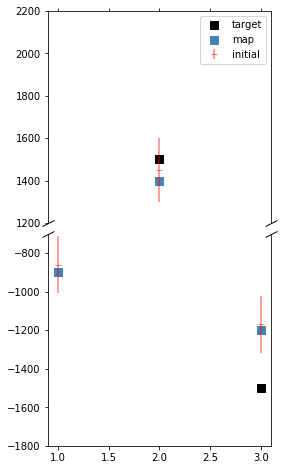

In [15]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex = True, figsize = (4,8))
fig.subplots_adjust(hspace = 0.05) #adjust space between axes

#data
ax1.errorbar(x,initial_z,yerr = initial_std_z, linestyle = 'None', marker = '_',color = 'red', alpha = 0.5, label = 'initial')
ax2.errorbar(x,initial_z,yerr = initial_std_z, linestyle = 'None', marker = '_',color = 'red', alpha = 0.5)
ax1.scatter(x,target_z, marker = 's', s = 50,color = 'black', label = 'target')
ax2.scatter(x,target_z, marker = 's', s = 50,color = 'black')
ax1.scatter(x,modes_z, marker = 's', s = 50,color = 'steelblue', label = 'map')
ax2.scatter(x,modes_z, marker = 's', s = 50,color = 'steelblue')


#formatting now
ax1.set_ylim(1200,2200)
ax2.set_ylim(-1800,-700)
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.legend()
plt.savefig(f'../figures/{model}_syntheticdata2.svg')
plt.show()


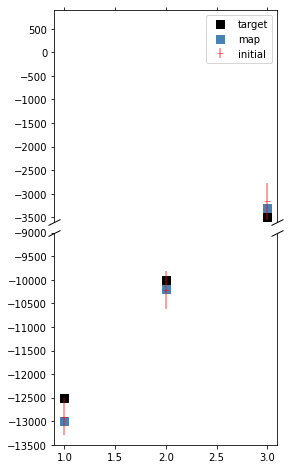

In [16]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex = True, figsize = (4,8))
fig.subplots_adjust(hspace = 0.05) #adjust space between axes

#data
ax1.errorbar(x,initial_slip,yerr = initial_std_slip, linestyle = 'None', marker = '_',color = 'red', alpha = 0.5, label = 'initial')
ax2.errorbar(x,initial_slip,yerr = initial_std_slip, linestyle = 'None', marker = '_',color = 'red', alpha = 0.5)
ax1.scatter(x,target_slip, marker = 's', s = 50,color = 'black', label = 'target')
ax2.scatter(x,target_slip, marker = 's', s = 50,color = 'black')
ax1.scatter(x,modes_slip, marker = 's', s = 50,color = 'steelblue', label = 'map')
ax2.scatter(x,modes_slip, marker = 's', s = 50,color = 'steelblue')


#formatting now
ax1.set_ylim(-3600,900)
ax2.set_ylim(-13500,-9000)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.legend()
plt.savefig(f'../figures/{model}_syntheticdata1.svg')
plt.show()
